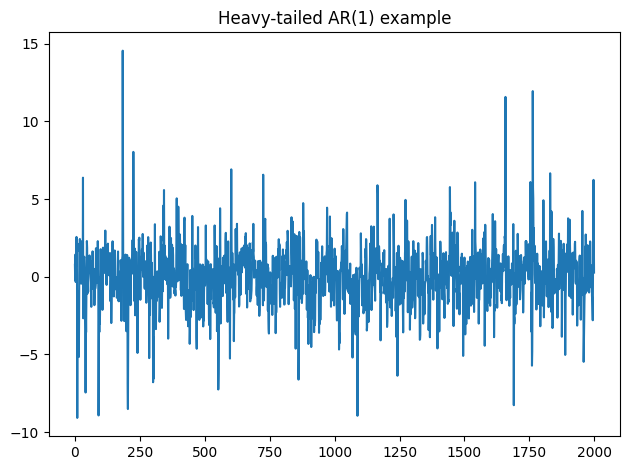

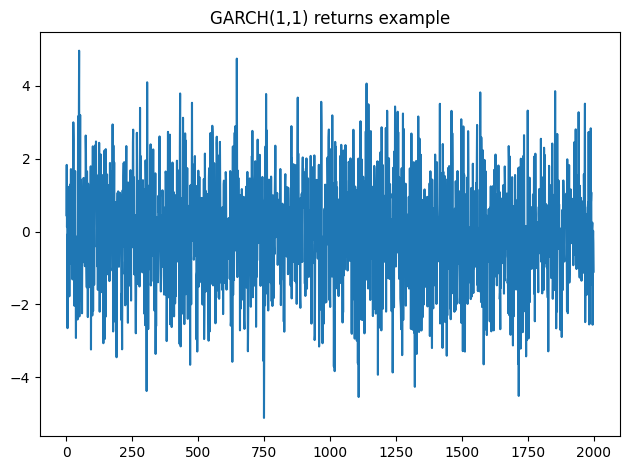

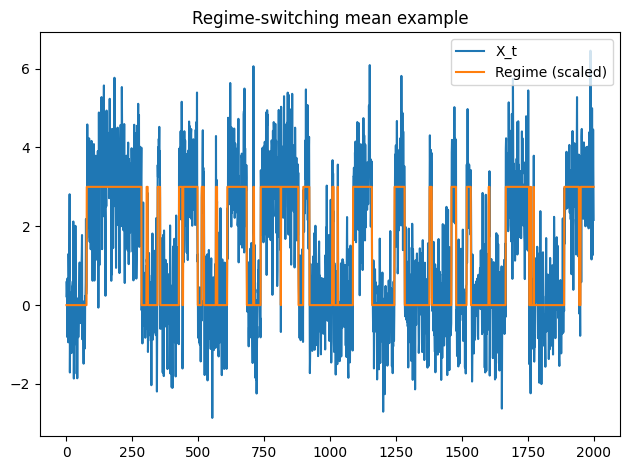

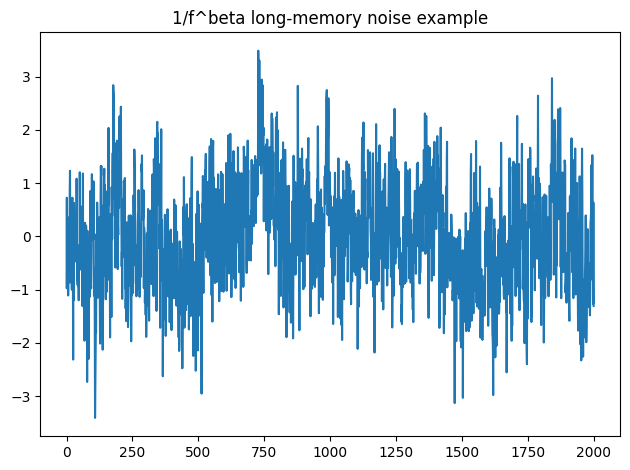

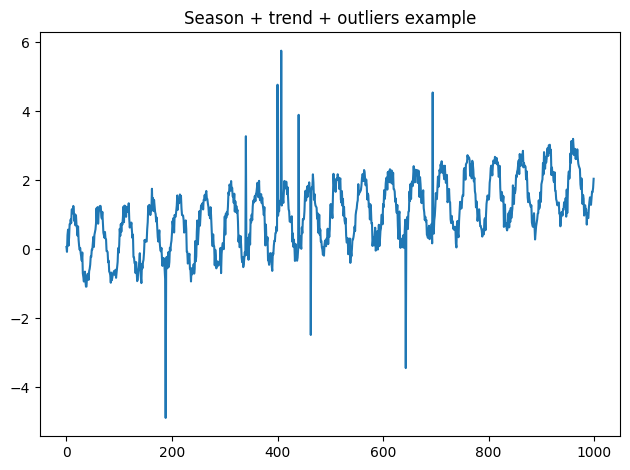

In [ ]:
import numpy as np

# -------------------------------
# (A) Heavy-Tailed AR(1) Process
# -------------------------------

def simulate_heavy_t_ar1(T, N=1, phi=0.5, df=3.0, burn_in=200, seed=None):
    """
    Heavy-tailed AR(1): X_t = phi * X_{t-1} + eps_t,
    where eps_t ~ Student-t(df).

    Parameters
    ----------
    T : int
        Length of series to return (after burn-in).
    N : int
        Number of independent series.
    phi : float
        AR(1) coefficient, |phi| < 1.
    df : float
        Degrees of freedom of Student-t innovations.
        df <= 2 → infinite variance.
    burn_in : int
        Extra steps to discard to reach stationarity.
    seed : int or None
        Random seed.

    Returns
    -------
    X : ndarray, shape (T, N)
        Simulated AR(1) series.
    """
    rng = np.random.default_rng(seed)
    total_T = T + burn_in

    eps = rng.standard_t(df, size=(total_T, N))

    X = np.zeros((total_T, N))
    # Start at zero (stationary mean) – burn-in handles transient anyway.
    for t in range(1, total_T):
        X[t] = phi * X[t - 1] + eps[t]

    # Drop burn-in
    return X[burn_in:]


# -------------------------------
# (B) GARCH(1,1) Volatility
# -------------------------------

def simulate_garch_11(T, omega=0.1, alpha=0.05, beta=0.9,
                      N=1, burn_in=200, seed=None):
    """
    GARCH(1,1): r_t = sigma_t * z_t,
    sigma_t^2 = omega + alpha * r_{t-1}^2 + beta * sigma_{t-1}^2,
    with z_t ~ N(0,1).

    Parameters
    ----------
    T : int
        Length of series to return (after burn-in).
    omega, alpha, beta : float
        GARCH(1,1) parameters. Typically alpha + beta < 1 for stationarity.
    N : int
        Number of independent series.
    burn_in : int
        Extra steps to discard.
    seed : int or None

    Returns
    -------
    r : ndarray, shape (T, N)
        Returns r_t.
    sigma : ndarray, shape (T, N)
        Conditional standard deviation sigma_t.
    """
    rng = np.random.default_rng(seed)
    total_T = T + burn_in

    z = rng.standard_normal(size=(total_T, N))
    r = np.zeros((total_T, N))
    sigma2 = np.zeros((total_T, N))

    # Initialize sigma^2 at unconditional variance if alpha + beta < 1
    if alpha + beta < 1:
        sigma2[0] = omega / (1 - alpha - beta)
    else:
        sigma2[0] = omega

    for t in range(1, total_T):
        r_sq_prev = r[t - 1] ** 2
        sigma2[t] = omega + alpha * r_sq_prev + beta * sigma2[t - 1]
        r[t] = np.sqrt(sigma2[t]) * z[t]

    return r[burn_in:], np.sqrt(sigma2[burn_in:])


# ------------------------------------------------
# (C) Regime-Switching Mean (2-state Markov chain)
# ------------------------------------------------

def simulate_regime_switching_mean(
    T,
    N=1,
    mu_A=0.0,
    mu_B=2.0,
    sigma_A=1.0,
    sigma_B=1.0,
    p_stay_A=0.95,
    p_stay_B=0.95,
    burn_in=100,
    seed=None,
):
    """
    Regime-switching process:
    X_t = mu_{s_t} + eps_t, eps_t ~ N(0, sigma_{s_t}^2),
    s_t ∈ {0 (A), 1 (B)} follows a 2-state Markov chain.

    Transition matrix:
        P = [[p_stay_A, 1 - p_stay_A],
             [1 - p_stay_B, p_stay_B]]

    Parameters
    ----------
    T : int
        Length (after burn-in).
    N : int
        Number of independent series.
    mu_A, mu_B : float
        Means of regimes A and B.
    sigma_A, sigma_B : float
        Std dev of regimes A and B.
    p_stay_A, p_stay_B : float
        Probability of staying in same regime for A and B.
    burn_in : int
    seed : int or None

    Returns
    -------
    X : ndarray, shape (T, N)
        Observations.
    S : ndarray, shape (T, N)
        Regime indicators (0 for A, 1 for B).
    """
    rng = np.random.default_rng(seed)
    total_T = T + burn_in

    # 0 = A, 1 = B
    S = np.zeros((total_T, N), dtype=int)
    # Initialize regimes (random)
    S[0] = rng.integers(0, 2, size=N)

    for t in range(1, total_T):
        prev = S[t - 1]
        # Draw uniform and decide whether to stay or switch
        u = rng.random(size=N)
        stay_A_mask = (prev == 0) & (u < p_stay_A)
        stay_B_mask = (prev == 1) & (u < p_stay_B)

        S[t] = prev  # default copy
        # Switch those not staying
        S[t][(prev == 0) & ~stay_A_mask] = 1
        S[t][(prev == 1) & ~stay_B_mask] = 0

    # Generate X given regimes
    X = np.zeros((total_T, N))
    for t in range(total_T):
        # Regime-dependent mean and sigma
        mu_t = np.where(S[t] == 0, mu_A, mu_B)
        sigma_t = np.where(S[t] == 0, sigma_A, sigma_B)
        X[t] = mu_t + sigma_t * rng.standard_normal(size=N)

    return X[burn_in:], S[burn_in:]


# -----------------------------------------------------
# (D) Long-Memory 1/f^β Noise via Spectral Synthesis
# -----------------------------------------------------

def simulate_1_over_f_noise(T, N=1, beta=0.8, seed=None):
    """
    Generate approximate 1/f^beta long-memory noise by shaping
    the power spectrum and inverse FFT.

    This is not an exact ARFIMA, but gives long-range dependence
    with power-law spectrum.

    Parameters
    ----------
    T : int
        Length of each series.
    N : int
        Number of series.
    beta : float
        Spectral slope: S(f) ∝ 1 / f^beta.
        beta in (0, 1) ~ weak to moderate long memory.
    seed : int or None

    Returns
    -------
    X : ndarray, shape (T, N)
        Long-memory time series (zero mean, unit-ish variance).
    """
    rng = np.random.default_rng(seed)

    # Frequencies for real FFT (rfft)
    freqs = np.fft.rfftfreq(T)
    # Avoid division by zero at f=0: set that amplitude separately
    amp = np.zeros_like(freqs)
    nonzero = freqs > 0
    amp[nonzero] = 1.0 / (freqs[nonzero] ** (beta / 2.0))

    X = np.zeros((T, N))
    for i in range(N):
        # Random complex spectrum with given amplitudes
        # real and imag parts ~ N(0, 1)
        re = rng.standard_normal(size=len(freqs))
        im = rng.standard_normal(size=len(freqs))
        # For real-valued signal, imaginary part at f=0 and Nyquist must be 0
        im[0] = 0.0
        spectrum = amp * (re + 1j * im)
        x = np.fft.irfft(spectrum, n=T)
        # Normalize to unit variance
        x = (x - x.mean()) / (x.std() + 1e-8)
        X[:, i] = x

    return X


# -----------------------------------------------------------
# (E) Seasonal Trend + Outliers (sinusoid + linear + spikes)
# -----------------------------------------------------------

def simulate_season_trend_outliers(
    T,
    N=1,
    season_period=24,
    A=1.0,
    trend_slope=0.001,
    noise_sigma=0.1,
    n_outliers=5,
    outlier_magnitude=5.0,
    seed=None,
):
    """
    Y_t = A * sin(2pi * t / S) + b * t + noise + occasional spikes.

    Parameters
    ----------
    T : int
        Length of series.
    N : int
        Number of series.
    season_period : int
        Season length S (e.g. 24 for daily cycle in hourly data).
    A : float
        Amplitude of sinusoidal season.
    trend_slope : float
        Linear trend slope b.
    noise_sigma : float
        Std dev of Gaussian noise eta_t.
    n_outliers : int
        Number of outlier timestamps per series.
    outlier_magnitude : float
        Size of outlier jump (±outlier_magnitude).
    seed : int or None

    Returns
    -------
    Y : ndarray, shape (T, N)
        Seasonal + trend + outlier time series.
    outlier_idx : list of lists
        For each series, the indices where outliers were added.
    """
    rng = np.random.default_rng(seed)

    t = np.arange(T)
    season = A * np.sin(2 * np.pi * t / season_period)
    trend = trend_slope * t

    Y = np.zeros((T, N))
    outlier_idx_all = []

    for i in range(N):
        noise = noise_sigma * rng.standard_normal(size=T)
        y = season + trend + noise

        # Choose outlier positions
        if n_outliers > 0:
            idx = rng.choice(T, size=n_outliers, replace=False)
            # Random sign for each outlier
            signs = rng.choice([-1.0, 1.0], size=n_outliers)
            y[idx] += signs * outlier_magnitude
        else:
            idx = np.array([], dtype=int)

        Y[:, i] = y
        outlier_idx_all.append(idx)

    return Y, outlier_idx_all


# -----------------
# Small demo usage
# -----------------

if __name__ == "__main__":
    import matplotlib.pyplot as plt

    T = 2000

    # (A) Heavy-tailed AR(1)
    X_A = simulate_heavy_t_ar1(T, N=1, phi=0.5, df=3, seed=42)
    plt.figure()
    plt.plot(X_A[:, 0])
    plt.title("Heavy-tailed AR(1) example")
    plt.tight_layout()

    # (B) GARCH(1,1)
    r_B, sigma_B = simulate_garch_11(T, omega=0.1, alpha=0.05, beta=0.9,
                                     N=1, seed=42)
    plt.figure()
    plt.plot(r_B[:, 0])
    plt.title("GARCH(1,1) returns example")
    plt.tight_layout()

    # (C) Regime-switching
    X_C, S_C = simulate_regime_switching_mean(T, N=1, mu_A=0, mu_B=3,
                                              p_stay_A=0.98, p_stay_B=0.98,
                                              seed=42)
    plt.figure()
    plt.plot(X_C[:, 0], label="X_t")
    plt.plot(S_C[:, 0] * 3, label="Regime (scaled)")
    plt.legend()
    plt.title("Regime-switching mean example")
    plt.tight_layout()

    # (D) 1/f noise
    X_D = simulate_1_over_f_noise(T, N=1, beta=0.8, seed=42)
    plt.figure()
    plt.plot(X_D[:, 0])
    plt.title("1/f^beta long-memory noise example")
    plt.tight_layout()

    # (E) Seasonal + trend + outliers
    Y_E, out_idx = simulate_season_trend_outliers(
        T=1000,
        N=1,
        season_period=50,
        A=1.0,
        trend_slope=0.002,
        noise_sigma=0.2,
        n_outliers=8,
        outlier_magnitude=4.0,
        seed=42,
    )
    plt.figure()
    plt.plot(Y_E[:, 0])
    plt.title("Season + trend + outliers example")
    plt.tight_layout()

    plt.show()
